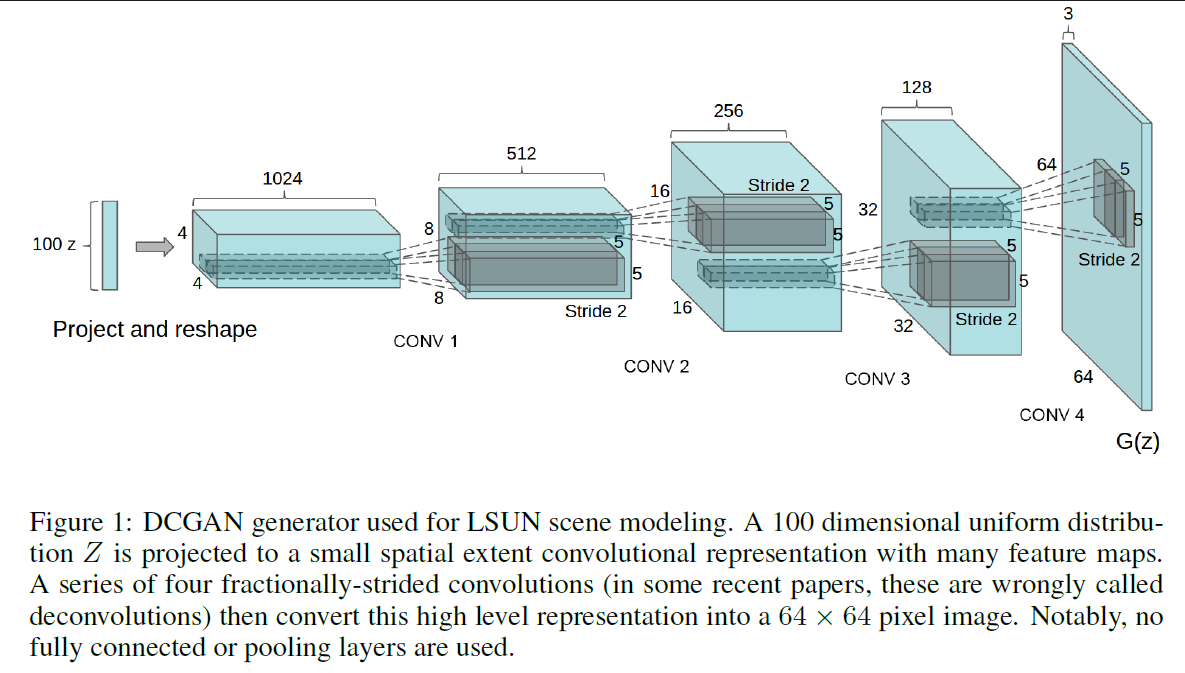

In [2]:
# !pip3 install chainer

     |████████████████████████████████| 1.0 MB 2.6 MB/s eta 0:00:01
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967732 sha256=f73473ca5602717941ca3d5f5f222af93190dd25b29660fd57920cf7526080b2
  Stored in directory: /home/beatrizcepa/.cache/pip/wheels/c5/01/d5/3ef194fa83dbf1d97bab826ca2bf235071f412861189a7b9df
Successfully built chainer


In [3]:
# verificar se estão corretos/se falta algo
import math
import numpy as np

import chainer
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, FunctionNode, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

'''The module chainerx aims to support a NumPy compatible interface with additional operations 
specific to neural networks'''
import chainerx 

import argparse
import os
import warnings

from PIL import Image

## Adding noise

In [ ]:
def add_noise(device, h, sigma=0.2):
    # Add some noise to every intermediate outputs of D before giving them to the next layers
    
    ''' chainer.config implements the local configuration of chainer. When a value is set to this object, 
    the configuration is only updated in the current thread. '''
    if chainer.config.train: # if the code is running in the training mode
        xp = device.xp # .xp gets the array module of the device's data array
       
        # TODO(niboshi): Support random.randn in ChainerX (?)
        
        if device.xp is chainerx:
            fallback_device = device.fallback_device
            
            ''' chainer.using_device(dev_spec) -> context manager to apply the thread-local device state
            The parameter is the device specifier.'''
            with chainer.using_device(fallback_device): 
                randn = device.send(fallback_device.xp.random.randn(*h.shape))
        else:
            randn = xp.random.randn(*h.shape)
        return h + sigma * randn
    else:
        return h

## Generator

In [4]:
class Generator(chainer.Chain):
    
    # n_hidden is the number of dimensions of the uniform noise distribution Z used as input of linear layer
    # wscale is the standard deviation of Gaussian distribution
    def __init__(self, n_hidden, bottom_width=4, ch=512, wscale=0.02):
        
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch # number of channels -> if ch=1024 the network is same as the above image
        self.bottom_width = bottom_width # width and height

        with self.init_scope(): 
            
            # chainer.initializers.Normal initializes array with a normal distribution -> w
            w = chainer.initializers.Normal(wscale)
            
            '''initialW is an initializer to initialize the weights. In this case, all weights were
            initialized from a zero-centered Normal distribution with standard deviation 0.02
            
            chainer.links.Linear(in_size, out_size, initialW)'''
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch,
                               initialW=w) # output of chainer.links.Linear is 1D
            
            '''chainer.links.Deconvolution2D(in_channels, out_channels, ksize=int, stride=int, 
                pad=int, nobias=bool, outsize=int, initialW=array, initial_bias=array, *, dilate=1, 
                groups=1)
            
            Because the first argument of L.Deconvolution is the channel size of input and the second 
            is the channel size of output, we can find that each layer halves the channel size, so the 
            divisions by 2, 4 and 8 '''
            self.dc1 = L.Deconvolution2D(ch, ch // 2, 4, 2, 1, initialW=w)
            self.dc2 = L.Deconvolution2D(ch // 2, ch // 4, 4, 2, 1, initialW=w)
            self.dc3 = L.Deconvolution2D(ch // 4, ch // 8, 4, 2, 1, initialW=w)
            self.dc4 = L.Deconvolution2D(ch // 8, 3, 3, 1, 1, initialW=w) # out_channels = 3 (??)
            
            
            # the parameter on BatchNormalization is the size (or shape) of channel dimensions
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)
            self.bn1 = L.BatchNormalization(ch // 2)
            self.bn2 = L.BatchNormalization(ch // 4)
            self.bn3 = L.BatchNormalization(ch // 8)

    
    
    def make_hidden(self, batchsize):
        # this fuction generates a uniform noise distribution Z
        
        dtype = chainer.get_dtype() # get_dtype resolves Chainer’s default data type object
        
        '''numpy.random.uniform (low, high, size) draws samples from a uniform distribution
        - size is the output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples 
        are drawn'''
        return numpy.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1))\
            .astype(dtype)

    
    
    def forward(self, z):
        # in this function, each layer is called and followed by relu, except the last layer (sigmoid)
        
        ''' When passing the output of a fully connected layer to a convolution layer, because 
        the convolutional layer needs additional dimensions for inputs. 
        
        As we can see in the 1st line, the output of the fully connected layer suffers BN, then relu 
        activation, and then is reshaped by reshape to add the dimensions of the channel (self.ch), 
        the width and the height of images.
        
        chainer.functions.reshape(x, shape) reshapes an input variable without copy
        -x (Variable or N-dimensional array) – Input variable.
        -shape (tuple of ints) – Expected shape of the output array. The number of elements which 
        the array of shape contains must be equal to that of input array '''        
        h = F.reshape(F.relu(self.bn0(self.l0(z))), 
                      (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.relu(self.bn1(self.dc1(h)))
        h = F.relu(self.bn2(self.dc2(h)))
        h = F.relu(self.bn3(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        return x
    

## Discriminator

In [ ]:
# the discriminator network almost mirrors the Generator, but is deeper
class Discriminator(chainer.Chain):

    def __init__(self, bottom_width=4, ch=512, wscale=0.02):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        
        with self.init_scope():
            
            ''' number of input channels of the first conv layer of D is the same as the number of 
            output channels of the last conv layer of G '''
            self.c0_0 = L.Convolution2D(3, ch // 8, 3, 1, 1, initialW=w)
            self.c0_1 = L.Convolution2D(ch // 8, ch // 4, 4, 2, 1, initialW=w)
            self.c1_0 = L.Convolution2D(ch // 4, ch // 4, 3, 1, 1, initialW=w)
            self.c1_1 = L.Convolution2D(ch // 4, ch // 2, 4, 2, 1, initialW=w)
            self.c2_0 = L.Convolution2D(ch // 2, ch // 2, 3, 1, 1, initialW=w)
            self.c2_1 = L.Convolution2D(ch // 2, ch // 1, 4, 2, 1, initialW=w)
            self.c3_0 = L.Convolution2D(ch // 1, ch // 1, 3, 1, 1, initialW=w)
            
            # chainer.links.Linear(in_size, out_size, initialW)
            self.l4 = L.Linear(bottom_width * bottom_width * ch, 1, initialW=w)
            
            # if use_gamma is True, use scaling parameter. Otherwise, use unit(1) which makes no effect
            self.bn0_1 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_0 = L.BatchNormalization(ch // 4, use_gamma=False)
            self.bn1_1 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_0 = L.BatchNormalization(ch // 2, use_gamma=False)
            self.bn2_1 = L.BatchNormalization(ch // 1, use_gamma=False)
            self.bn3_0 = L.BatchNormalization(ch // 1, use_gamma=False)

    def forward(self, x):
        device = self.device
        h = add_noise(device, x)
        h = F.leaky_relu(add_noise(device, self.c0_0(h)))
        h = F.leaky_relu(add_noise(device, self.bn0_1(self.c0_1(h))))
        h = F.leaky_relu(add_noise(device, self.bn1_0(self.c1_0(h))))
        h = F.leaky_relu(add_noise(device, self.bn1_1(self.c1_1(h))))
        h = F.leaky_relu(add_noise(device, self.bn2_0(self.c2_0(h))))
        h = F.leaky_relu(add_noise(device, self.bn2_1(self.c2_1(h))))
        h = F.leaky_relu(add_noise(device, self.bn3_0(self.c3_0(h))))
        return self.l4(h)
    

## Updater

In [ ]:
'''Usually, the default updaters pre-defined in Chainer take only one model. So, we need to 
define a custom updater for GAN training. The definition of DCGANUpdater minimizes the loss of 
the discriminator and that of the generator alternately.

chainer.training.updaters.StandardUpdater -> Standard implementation of Updater'''

class DCGANUpdater(chainer.training.updaters.StandardUpdater):

    def __init__(self, *args, **kwargs):
        self.gen, self.dis = kwargs.pop('models') # an additional keyword argument 'models' is required
        super(DCGANUpdater, self).__init__(*args, **kwargs)

        
    # discriminator loss
    def loss_dis(self, dis, y_fake, y_real):
        '''The function must accept arbitrary arguments and return one Variable object that 
        represents the loss (or objective) value. Returned value must be a Variable derived 
        from the input Variable object.'''
        
        batchsize = len(y_fake)
        
        '''chainer.functions.softplus(x, beta=1.0) -> softplus activation. Element-wise softplus 
        function. The softplus function is the smooth approximation of ReLU. The function becomes 
        curved and akin to ReLU as the  is increasing.
        -x (Variable or N-dimensional array) – Input variable.
        -beta (float) – Parameter beta
        
        chainer.functions.sum(x, axis=None, keepdims=False) -> Sum of array elements over a given axis.
        -x (Variable or N-dimensional array) – Elements to sum. 
        -axis (None, int, or tuple of int) – Axis along which a sum is performed. The default (axis = None) 
        is perform a sum over all the dimensions of the input array.
        -keepdims (bool) – If True, the specified axes are remained as axes of length one'''
        L1 = F.sum(F.softplus(-y_real)) / batchsize # loss of the real samples
        L2 = F.sum(F.softplus(y_fake)) / batchsize # loss of the synthetic samples
        loss = L1 + L2
        
        '''chainer.report(values, observer=None) -> Reports observed values with the current 
        reporter object.
        -values (dict) – Dictionary of observed values
        -observer – Observer object. Its object ID is used to retrieve the observer name, which 
        is used as the prefix of the registration name of the observed value.'''
        chainer.report({'loss': loss}, dis)
        
        return loss

    
    
    # generator loss
    def loss_gen(self, gen, y_fake):
        '''The function must accept arbitrary arguments and return one Variable object that 
        represents the loss (or objective) value. Returned value must be a Variable derived 
        from the input Variable object.'''
        
        batchsize = len(y_fake)
        loss = F.sum(F.softplus(-y_fake)) / batchsize
        chainer.report({'loss': loss}, gen)
        return loss

    
    
    def update_core(self):
        
        # access model optimizers
        gen_optimizer = self.get_optimizer('gen')
        dis_optimizer = self.get_optimizer('dis')
        
        '''self.get_iterator('main') -> access the iterator
        self.get_iterator('main').next() creates next minibatch of training data'''
        batch = self.get_iterator('main').next()
        
        
        device = self.device
        
        # self.converter copies batch to the device
        x_real = Variable(self.converter(batch, device)) / 255. # make it a Variable object

        gen, dis = self.gen, self.dis
        batchsize = len(batch)
        
        # output of D for the real samples
        y_real = dis(x_real)

        # making the uniform noise distribution a Variable object
        z = Variable(device.xp.asarray(gen.make_hidden(batchsize)))
        
        # output of G
        x_fake = gen(z)
        
        # output of D for the synthetic sampleS
        y_fake = dis(x_fake)
        
        

        '''update(lossfun, *args, **kwds) -> updates the parameters of the target link
        -lossfun (callable) – Loss function. If it is given, this method typically clears 
        the gradients, calls the loss function with given extra arguments, and calls the 
        backward() method of its output to compute the gradients. 
        -args – Arguments for the loss function.
        -kwds – Arguments for the loss function.'''
        dis_optimizer.update(self.loss_dis, dis, y_fake, y_real)
        gen_optimizer.update(self.loss_gen, gen, y_fake)
        

## Visualize

In [ ]:
def out_generated_image(gen, dis, rows, cols, seed, dst):
    @chainer.training.make_extension() # make a new extension
    
    def make_image(trainer):
        np.random.seed(seed)
        n_images = rows * cols
        xp = gen.xp # .xp gets the array module of gen's data array
        z = Variable(xp.asarray(gen.make_hidden(n_images)))
        
        
        '''chainer.using_config(name, value, config=chainer.config) -> Context manager to temporarily 
        change the thread-local configuration.
        -name (str) – Name of the configuration to change.
        -value – Temporary value of the configuration entry.
        -config (LocalConfig) – Configuration object. Chainer’s thread-local configuration is used by default.'''
        with chainer.using_config('train', False):
            x = gen(z)
        
        
        '''chainer.backends.cuda.to_cpu(array) -> Copies the given GPU array to host CPU.'''
        x = chainer.backends.cuda.to_cpu(x.array)
        
        np.random.seed()

        '''numpy.clip(a, a_min, a_max, out=None, **kwargs) -> Clip (limit) the values in an array.
        Given an interval, values outside the interval are clipped to the interval edges. For example, 
        if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 
        1 become 1.'''
        x = np.asarray(np.clip(x * 255, 0.0, 255.0), dtype=np.uint8)
        
        '''array.shape returns a tuple with each index having the number of corresponding elements. 
        (2, 4) means that the array has 2 dimensions, where the first dimension has 2 elements and 
        the second has 4.'''
        _, _, H, W = x.shape
        
        
        '''numpy.reshape(newshape) -> Gives a new shape to an array without changing its data.
        -newshape (int or tuple of ints) - new shape of the array'''
        x = x.reshape((rows, cols, 3, H, W))
        x = x.transpose(0, 3, 1, 4, 2)
        x = x.reshape((rows * H, cols * W, 3))

        preview_dir = '{}/preview'.format(dst)
        preview_path = preview_dir +\
            '/image{:0>8}.png'.format(trainer.updater.iteration)
        if not os.path.exists(preview_dir):
            os.makedirs(preview_dir)
        Image.fromarray(x).save(preview_path)
    return make_image

## Main

In [ ]:
def main():
    parser = argparse.ArgumentParser(description='Chainer example: DCGAN')
    parser.add_argument('--batchsize', '-b', type=int, default=50,
                        help='Number of images in each mini-batch')
    parser.add_argument('--epoch', '-e', type=int, default=1000,
                        help='Number of sweeps over the dataset to train')
    parser.add_argument('--device', '-d', type=str, default='-1',
                        help='Device specifier. Either ChainerX device '
                        'specifier or an integer. If non-negative integer, '
                        'CuPy arrays with specified device id are used. If '
                        'negative integer, NumPy arrays are used')
    parser.add_argument('--dataset', '-i', default='',
                        help='Directory of image files.  Default is cifar-10.')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--resume', '-r', type=str,
                        help='Resume the training from snapshot')
    parser.add_argument('--n_hidden', '-n', type=int, default=100,
                        help='Number of hidden units (z)')
    parser.add_argument('--seed', type=int, default=0,
                        help='Random seed of z at visualization stage')
    parser.add_argument('--snapshot_interval', type=int, default=1000,
                        help='Interval of snapshot')
    parser.add_argument('--display_interval', type=int, default=100,
                        help='Interval of displaying log to console')
    group = parser.add_argument_group('deprecated arguments')
    group.add_argument('--gpu', '-g', dest='device',
                       type=int, nargs='?', const=0,
                       help='GPU ID (negative value indicates CPU)')
    args = parser.parse_args()

    
    
    if chainer.get_dtype() == numpy.float16:
        warnings.warn(
            'This example may cause NaN in FP16 mode.', RuntimeWarning)

    device = chainer.get_device(args.device)
    device.use()

    print('Device: {}'.format(device))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# n_hidden: {}'.format(args.n_hidden))
    print('# epoch: {}'.format(args.epoch))
    print('')

   

    # Set up a neural network to train -> making the instances of the generator and the discriminator
    gen = Generator(n_hidden=args.n_hidden)
    dis = Discriminator()

    # Copy the models to the device
    gen.to_device(device)  
    dis.to_device(device)

   

    # Setup an optimizer
    def make_optimizer(model, alpha=0.0002, beta1=0.5):
        
        '''chainer.optimizers.Adam(alpha=float, beta1=float) -> adam optimizer
        -alpha - Coefficient of learning rate
        -beta1 - Exponential decay rate of the first order moment. '''
        optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1)
        
        
        '''setup(link) is a method from the Optimizer class that sets a target link and 
        initializes the optimizer states.'''
        optimizer.setup(model)
        
        
        '''add_hook(hook, name=None, timing='auto') is a method from the Optimizer class 
        that registers a hook function. Hook function is typically called right after the 
        gradient computation, though the timing depends on the optimization method, and 
        the timing attribute.
        -hook (callable) – Hook function.
        -name (str) – Name of the registration. If omitted, hook.name is used by default.'''
        optimizer.add_hook(
            '''chainer.optimizer_hooks.WeightDecay(rate) is the Optimizer/UpdateRule hook 
            function for weight decay regularization. This hook function adds a scaled 
            parameter to the corresponding gradient. It can be used as a regularization.
            -rate (float) – Coefficient for the weight decay.'''
            chainer.optimizer_hooks.WeightDecay(0.0001), 'hook_dec')
        return optimizer
    
    
    
    # make an optimizer for each model
    opt_gen = make_optimizer(gen)
    opt_dis = make_optimizer(dis)

        
    
    if args.dataset == '':
        ''' Load the CIFAR10 dataset if args.dataset is not specified
        
        chainer.datasets.get_cifar10(withlabel=bool, ndim=int, scale=float, dtype=None)
        -withlabel(bool) – if True, it returns datasets with labels. In this case, each example 
        is a tuple of an image and a label. Otherwise, the datasets only contain images.
        -ndim (int) – number of dimensions of each image.
        -scale (float) – Pixel value scale.
        
        CIFAR-10 is a set of small natural images. Each example is an RGB color image of size 32x32. 
        In the original images, each of R, G, B of pixels is represented by one-byte unsigned integer 
        (i.e. from 0 to 255). This function changes the scale of pixel values into [0, scale] float 
        values.'''
        train, _ = chainer.datasets.get_cifar10(withlabel=False, scale=255.)
    else:
        all_files = os.listdir(args.dataset)
        image_files = [f for f in all_files if ('png' in f or 'jpg' in f)]
        print('{} contains {} image files'
              .format(args.dataset, len(image_files)))
        train = chainer.datasets\
            .ImageDataset(paths=image_files, root=args.dataset)

    
    
    # Setup an iterator
    train_iter = chainer.iterators.SerialIterator(train, args.batchsize)

    
    
    # Setup an updater
    '''iterator, optimizer and device are parameters of the chainer.training.updaters.StandardUpdater
    -iterator – Dataset iterator for the training dataset
    -optimizer – Optimizer to update parameters
    -device (device specifier) – Device to which the model is sent'''
    updater = DCGANUpdater(
        models=(gen, dis),
        iterator=train_iter,
        
        '''the optimizer argument takes a dictionary. As the two different models require two 
        different optimizers, to specify the different optimizers for the models we give a 
        dictionary, {'gen': opt_gen, 'dis': opt_dis}, to the optimizer argument'''
        optimizer={
            'gen': opt_gen, 'dis': opt_dis},
        device=device)

    
    
    # Setup a trainer
    
    '''chainer.training.Trainer(updater, stop_trigger=None, out='result', extensions=None) -> standard 
    training loop in Chainer. Trainer is an implementation of a training loop.
    -updater (Updater) – Updater object. It defines how to update the models.
    -stop_trigger – Trigger that determines when to stop the training loop. If it is not callable, it 
    is passed to IntervalTrigger. In most cases, IntervalTrigger is used, in which case users can simply 
    specify a tuple of the interval length and its unit, like (1000, 'iteration') or (1, 'epoch').
    -out – Output directory.
    -extensions – Extensions registered to the trainer. Extensions are callable objects that take the 
    trainer object as the argument. Users can register extensions to the trainer by calling the extend()
    method, where some configurations can be added.'''
    trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)
    
    

    snapshot_interval = (args.snapshot_interval, 'iteration')
    display_interval = (args.display_interval, 'iteration')
    
    '''extend(extension, name=None, trigger=None, priority=None, *, call_before_training=False, **kwargs)
    -extension – Extension to register.
    -name (str) – Name of the extension. If it is omitted, the Extension.name attribute of the extension
    is used or the Extension.default_name attribute of the extension if name is is set to None or is 
    undefined. Note that the name would be suffixed by an ordinal in case of duplicated names.
    -trigger (tuple or Trigger) – Trigger object that determines when to invoke the extension. If the 
    trigger is not callable, it is passed to IntervalTrigger to build an interval trigger. 
    -call_before_training (bool) – Flag to call extension before training. Default is False.
    -priority (int) – Invocation priority of the extension. Extensions are invoked in the descending order 
    of priorities in each iteration. If this is None, extension.priority is used instead.'''
    trainer.extend(
        '''chainer.training.extensions.snapshot(filename='snapshot_iter_{.updater.iteration}')
        Returns a trainer extension to take snapshots of the trainer. This extension serializes the trainer 
        object and saves it to the output directory. It is used to support resuming the training loop from 
        the saved state. This extension is called once per epoch by default. To take a snapshot at a 
        different interval, a trigger object specifying the required interval can be passed along with 
        this extension to the extend() method of the trainer. The default priority is -100, which is lower 
        than that of most built-in extensions.
        -filename (str) – Name of the file into which the trainer is serialized.'''
        extensions.snapshot(filename='snapshot_iter_{.updater.iteration}.npz'),
        trigger=snapshot_interval)
    
    
    
    '''chainer.training.extensions.snapshot_object(target, filename) -> Returns a trainer extension to take
    snapshots of a given object. This extension is called once per epoch by default. To take a snapshot at a 
    different interval, a trigger object specifying the required interval can be passed along with 
    this extension to the extend() method of the trainer. The default priority is -100, which is lower 
    than that of most built-in extensions.
    -target – Object to serialize.
    -filename (str) – Name of the file into which the object is serialized.'''
    trainer.extend(extensions.snapshot_object(
        gen, 'gen_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
    
    trainer.extend(extensions.snapshot_object(
        dis, 'dis_iter_{.updater.iteration}.npz'), trigger=snapshot_interval)
    
    
    
    '''chainer.training.extensions.LogReport(trigger=(1, 'epoch')) -> Trainer extension to output the 
    accumulated results to a log file.
    -trigger – Trigger that decides when to aggregate the result and output the values. This is 
    distinct from the trigger of this extension itself. If it is a tuple in the form <int>, 'epoch' or 
    <int>, 'iteration', it is passed to IntervalTrigger.'''
    trainer.extend(extensions.LogReport(trigger=display_interval))
    
    
    
    '''chainer.training.extensions.PrintReport(entries) -> Trainer extension to print the accumulated 
    results. This extension uses the log accumulated by a LogReport extension to print specified entries
    of the log in a human-readable format.
    -entries (list of str) – List of keys of observations to print.'''
    trainer.extend(extensions.PrintReport([
        'epoch', 'iteration', 'gen/loss', 'dis/loss',
    ]), trigger=display_interval)
    
    
    
    '''chainer.training.extensions.ProgressBar(update_interval=int) -> Trainer extension to print a 
    progress bar and recent training status. This extension prints a progress bar at every call. It 
    watches the current iteration and epoch to print the bar.'''
    trainer.extend(extensions.ProgressBar(update_interval=10))
    
    
    trainer.extend(
        out_generated_image(
            gen, dis,
            10, 10, args.seed, args.out),
        trigger=snapshot_interval)
    
    

    if args.resume is not None:
        # Resume from a snapshot
        '''chainer.serializers.load_npz(file, obj) -> Loads an object from the file in NPZ format.
        -file (str or file-like) – File to be loaded.
        -obj – Object to be deserialized.'''
        chainer.serializers.load_npz(args.resume, trainer)

    
    
    # Run the training
    trainer.run()